### Want to explore finding example units that only confidence selective, and not preference selective. 
- Show PSTHs where that's the case

In [25]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.classifier_utils as classifier_utils

import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import matplotlib
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
import utils.anova_utils as anova_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData
from constants.behavioral_constants import *
from constants.decoding_constants import *
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
# from scripts.anova_analysis.run_anova import load_data
import scipy
import argparse
import copy
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import itertools

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def load_data(session, args):
    beh = behavioral_utils.load_behavior_from_args(session, args)
    frs = io_utils.get_frs_from_args(args, session)
    return beh, frs

In [3]:
args = argparse.Namespace(
    **AnovaConfigs()._asdict()
)
args.conditions = ["BeliefConf", "BeliefPartition"]
args.beh_filters = {"Response": "Correct", "Choice": "Chose"}
args.window_size = 500
args.sig_thresh = "99th"
args.trial_event = "StimOnset"


In [4]:
conf_res = io_utils.read_anova_good_units(args, "99th", "BeliefConf", return_pos=True)
pref_res = io_utils.read_anova_good_units(args, "99th", "BeliefPref", return_pos=True)

In [5]:
pref_units = pref_res[pref_res.p == "99th"].PseudoUnitID.unique()
conf_units = conf_res[conf_res.p == "99th"].PseudoUnitID.unique()


In [6]:
just_conf = conf_res[(conf_res.p == "99th") & (~conf_res.PseudoUnitID.isin(pref_units))]
just_pref = pref_res[(pref_res.p == "99th") & (~pref_res.PseudoUnitID.isin(conf_units))]

In [7]:
just_conf.PseudoUnitID.nunique() / len(conf_units)

0.4833538840937115

In [8]:
just_pref.PseudoUnitID.nunique() / len(pref_units)

0.2763385146804836

In [9]:
col_name = f"x_BeliefConf_comb_time_fracvar"
summed = just_conf.groupby(["PseudoUnitID", "feat", "structure_level2_cleaned"])[col_name].sum().reset_index()
top = summed.sort_values(col_name, ascending=False).drop_duplicates('PseudoUnitID')
trial_event = "StimOnset"


### Plot some examples

Skipping 2018062236


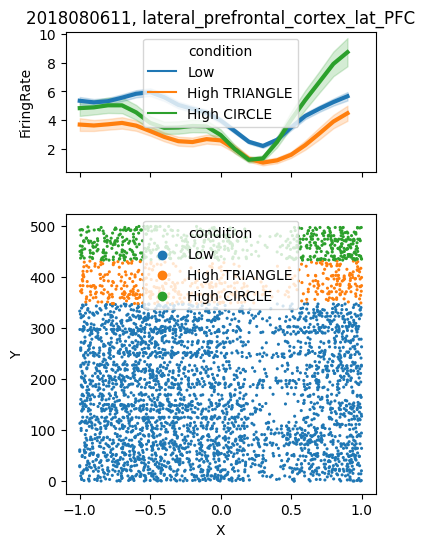

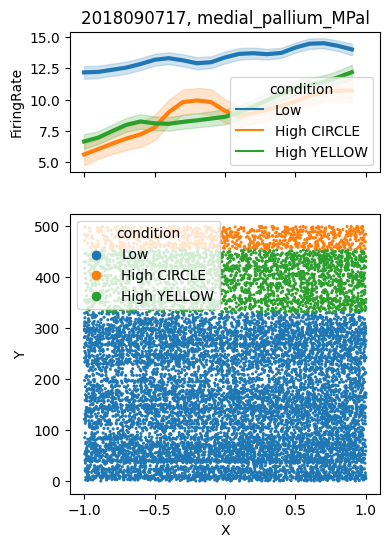

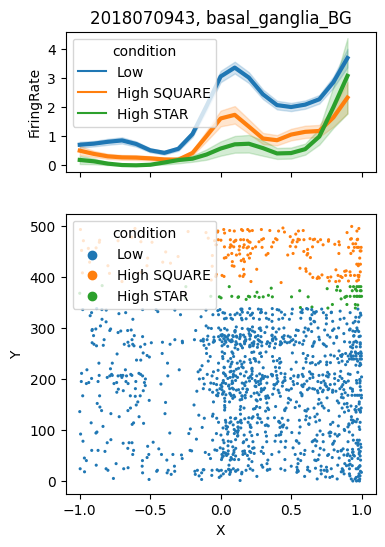

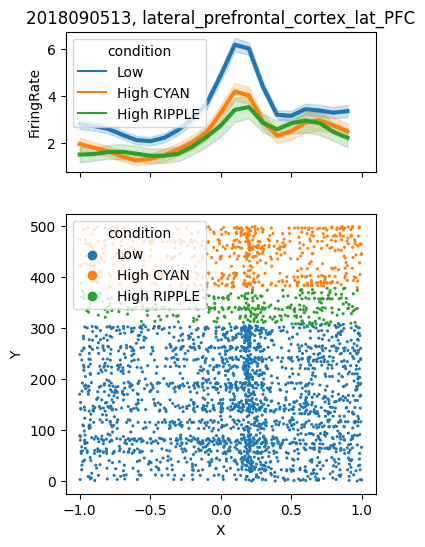

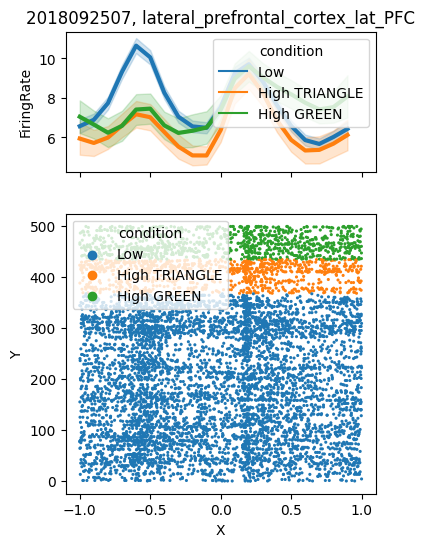

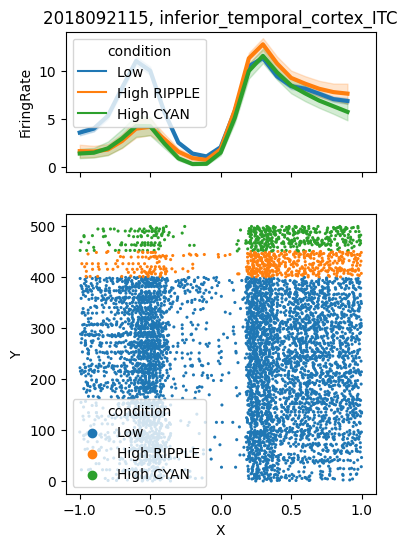

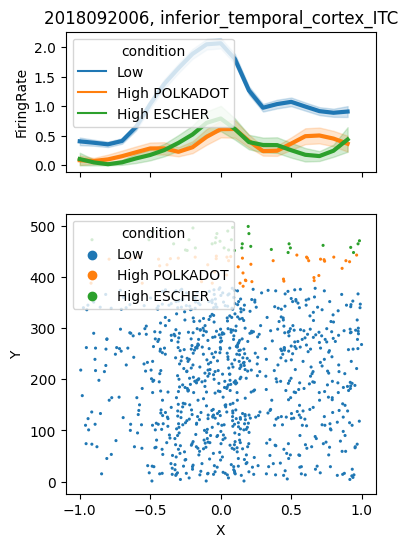

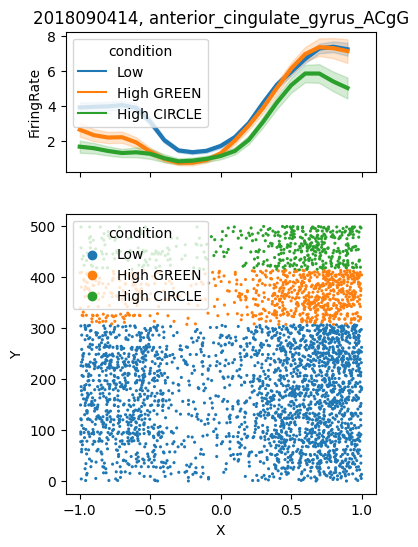

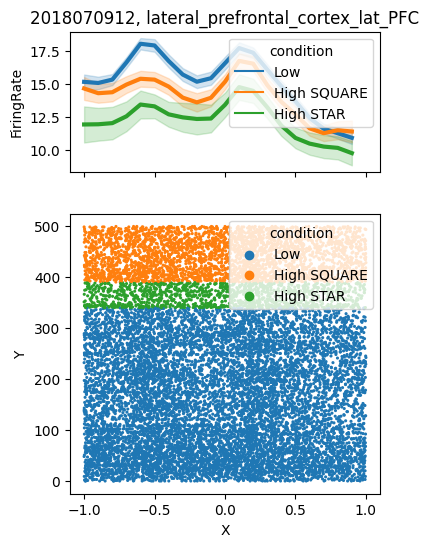

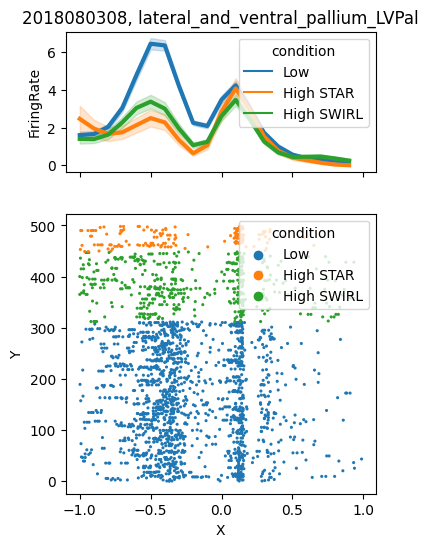

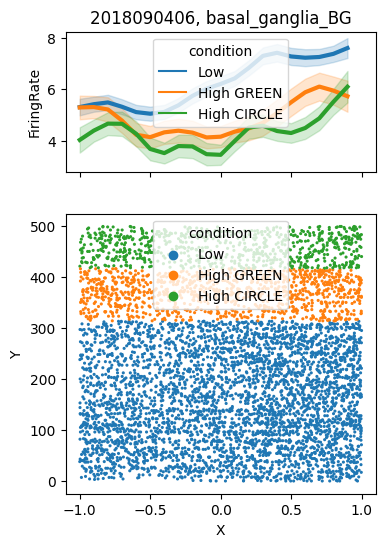

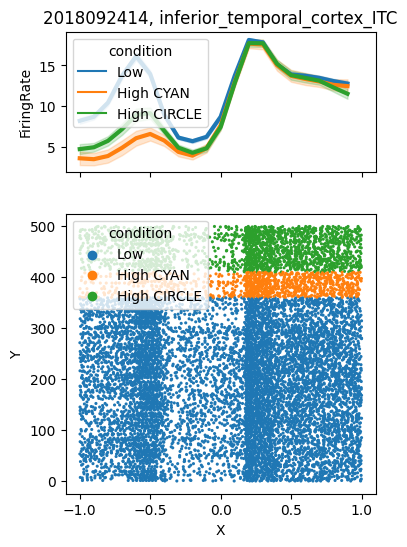

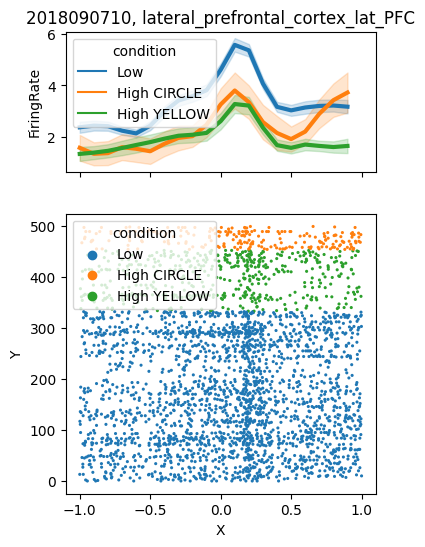

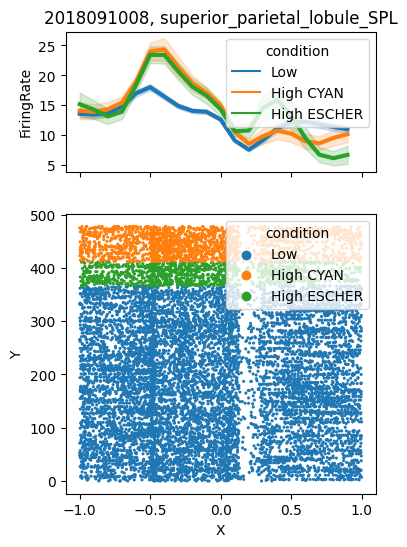

In [10]:
for i in range(15):

    unit_id = top.iloc[i].PseudoUnitID
    session = int(unit_id / 100)
    args.trial_event = trial_event
    trial_interval = get_trial_interval(trial_event)
    args.trial_interval = trial_interval
    args.beh_filters = {}
    beh, frs = load_data(session, args)

    rules = beh.groupby("CurrentRule").BlockNumber.nunique().reset_index(name="num_blocks").sort_values(by="num_blocks", ascending=False)
    if rules.iloc[1].num_blocks < 3: 
        print(f"Skipping {unit_id}")
        continue

    pair = (rules.iloc[0].CurrentRule, rules.iloc[1].CurrentRule)
    beh = behavioral_utils.get_belief_partitions_of_pair(beh, pair)


    fig, axs = plt.subplots(2, 1, figsize=(4, 6), sharex='col', height_ratios=[1, 2])

    beh["condition"] = beh["BeliefPartition"]
    order = beh.condition.unique()
    frs = frs[frs.PseudoUnitID == unit_id]
    sns.lineplot(
        pd.merge(frs, beh, on="TrialNumber"), 
        x="Time", y="FiringRate", 
        linewidth=3,
        errorbar="se", 
        hue="condition",
        hue_order=order,
        ax=axs[0]
    )
    subject = behavioral_utils.get_sub_for_session(session)
    sub_beh = beh.sample(500) if len(beh) > 500 else beh
    visualization_utils.visualize_unit_raster(subject, session, unit_id, sub_beh, trial_interval, ax=axs[1], hue_order=order)
    axs[0].set_title(f"{unit_id}, {top.iloc[i].structure_level2_cleaned}")


In [35]:
beh = behavioral_utils.get_belief_partitions_of_pair(beh, pair)

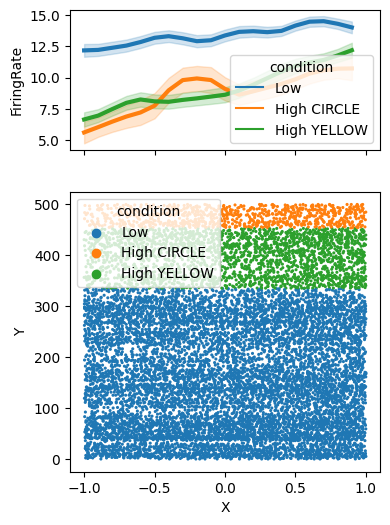

In [37]:
fig, axs = plt.subplots(2, 1, figsize=(4, 6), sharex='col', height_ratios=[1, 2])

order = beh.condition.unique()

beh["condition"] = beh["BeliefPartition"]
frs = frs[frs.PseudoUnitID == unit_id]
sns.lineplot(
    pd.merge(frs, beh, on="TrialNumber"), 
    x="Time", y="FiringRate", 
    linewidth=3,
    errorbar="se", 
    hue="condition",
    hue_order=order,
    ax=axs[0]
)
subject = behavioral_utils.get_sub_for_session(session)
sub_beh = beh.sample(500) if len(beh) > 500 else beh
visualization_utils.visualize_unit_raster(subject, session, unit_id, sub_beh, trial_interval, ax=axs[1], hue_order=order)

### Per region, what is the fraction of confidence-selective units that are not preference selective?

In [21]:
just_conf_reg = just_conf.groupby("structure_level2_cleaned").PseudoUnitID.nunique().reset_index(name="num_just_conf")
conf_reg = conf_res.groupby("structure_level2_cleaned").PseudoUnitID.nunique().reset_index(name="num_conf")

merged = pd.merge(conf_reg, just_conf_reg, on="structure_level2_cleaned")
merged["frac"] = merged["num_just_conf"] / merged["num_conf"]

In [26]:
merged[merged.structure_level2_cleaned.isin(REGIONS_OF_INTEREST)]

,structure_level2_cleaned,num_conf,num_just_conf,frac
0,amygdala_Amy,47,18,0.382979
1,anterior_cingulate_gyrus_ACgG,64,37,0.578125
2,basal_ganglia_BG,59,29,0.491525
7,inferior_temporal_cortex_ITC,123,62,0.504065
9,lateral_prefrontal_cortex_lat_PFC,186,87,0.467742
10,medial_pallium_MPal,36,17,0.472222
